# Songs

### 1-13-17

## Problem Statement
The company CEO asked you very specific questions:  
--What are the top 3 and the bottom 3 states in terms of number of users?  
--What are the top 3 and the bottom 3 states in terms of user engagement? You can choose how to mathematically define user engagement. What the CEO cares about here is in which states users are using the product a lot/very little.  
--The CEO wants to send a gift to the first user who signed-up for each state. That is, the first user who signed-up from California, from Oregon, etc. Can you give him a list of those users?  
--Build a function that takes as an input any of the songs in the data and returns the most likely song to be listened next. That is, if, for instance, a user is currently listening to "Eight Days A Week", which song has the highest probability of being played right after it by the same user? This is going to be v1 of a song recommendation model.  
--How would you set up a test to check whether your model works well and is improving engagement?

## Data Description
Fields:  
--id : unique identifier of the row  
--user_id : user id who listened to a given song  
--user_state : where the user is based  
--user_sign_up_date : when the user signed-up  
--song_played : the song that was listened  
--time_played : at which time the user started listening to the song (local time)  

## Part 0 - Setup, Import, Exploration

Before any complex analysis, let's perform some exploratory analysis and sanity checks to ensure our data makes sense.

In [131]:
# setup and import
## basics
import pandas as pd
import numpy as np
from pandas import DataFrame, Series

## date manipulation
from dateutil.parser import parse

## plotting
import matplotlib.pyplot as plt
%pylab inline

## formulas
import patsy

Populating the interactive namespace from numpy and matplotlib


In [132]:
# grab the json data file and print the first few rows
songs = pd.read_json('song.json')

songs.head()
# Looks how we would expect!

,id,song_played,time_played,user_id,user_sign_up_date,user_state
0,GOQMMKSQQH,Hey Jude,2015-06-11 21:51:35,122,2015-05-16,Louisiana
1,HWKKBQKNWI,We Can Work It Out,2015-06-06 16:49:19,3,2015-05-01,Ohio
2,DKQSXVNJDH,Back In the U.S.S.R.,2015-06-14 02:11:29,35,2015-05-04,New Jersey
3,HLHRIDQTUW,P.s. I Love You,2015-06-08 12:26:10,126,2015-05-16,Illinois
4,SUKJCSBCYW,Sgt. Pepper's Lonely Hearts Club Band,2015-06-28 14:57:00,6,2015-05-01,New Jersey


In [133]:
# quick check for number of rows just to understand size of data
len(songs)
# ok, not too bad. not a lot of data here.

4000

In [134]:
# since we know that the data has been described as messy, let's try and figure out how messy. first, let's check for missing
# values in each column by defining a function to check 

def fillprc(dff):
    fillprc = [] # initialize empty list to be returned later
    dfcols = list(dff.columns.values) # get list of all column names
    for i in dfcols: # loop through each column and get percentage filled, defined as ratio of lengths
        colname = i
        collfillprc = float(dff[i].value_counts().sum())/dff[i].value_counts(dropna=False).sum()
    
        fillprc.append((colname,collfillprc)) # add tuple of colname and percentage filled to list
     
    missinglist = [f for f in fillprc if f[1] != 1] # Filter fillprc list for less than 100%

    return missinglist

In [135]:
# call the function on our df
fillprc(songs)
# appears as though all of our columns are 100% filled - hardly what I would call messy!

[]

In [136]:
# now let's check the data types of each field
songs.dtypes
# all looks good! later we will convert the date fields into date objects so we can extract meaningful information.

id                   object
song_played          object
time_played          object
user_id               int64
user_sign_up_date    object
user_state           object
dtype: object

In [137]:
# check for duplicate rows
(len(songs.drop_duplicates())*1.0)/len(songs)
# a value of 1.0 means the length of the de-duplicated list is the same as the original list, implying no duplicate values

1.0

In [138]:
# let's get a quick view of song counts
songs['song_played'].value_counts()

Come Together                                              408
Revolution                                                 321
Get Back                                                   279
Let It Be                                                  184
A Day In The Life                                          170
While My Guitar Gently Weeps                               165
Back In the U.S.S.R.                                       163
Hello Goodbye                                              161
Here Comes The Sun                                         127
Hey Jude                                                   120
Eleanor Rigby                                              116
Lucy In The Sky With Diamonds                              113
We Can Work It Out                                          99
Birthday                                                    79
Reprise / Day in the Life                                   69
Yesterday                                              

Looking above, we can see this is a bit of a mess. For example, we see that "The Ballad of John and Yoko" has 41 plays, and another song titled "BALLAD OF JOHN AND YOKO" has 6 plays. I prefer the Stones to the Beatles, and Led Zeppelin to both of them, but I am fairly certain that these two songs should only be one entry with 47 plays. Let's use the package NLTK to see if we can clean this up just a bit.

In [139]:
# first, let's see if we have any capitalization issues by comparing how many unique entries are in the song list before and 
# after converting to lower case
len(songs['song_played'].unique()), len(songs['song_played'].str.lower().unique())
# 100 unique songs for each list - capitalization is not an issue

(100, 100)

In [140]:
# import package and get stopwords
from nltk.corpus import stopwords

# create list of unique stopwords
stops = list(set(stopwords.words('english')))

In [141]:
# let's compare how many unique songs we have before and after removing stopwords
# define a function to remove stopwords
def remove_stop(song):
    c = [i for i in song.lower().split() if i not in stops] # convert song to list, only keep words not in stopwords list
    d = ' '.join(c) # turn it back into a string
    return d # return the new string without stopwords

songs['song_clean'] = songs['song_played'].map(remove_stop) # create a new column in DF by mapping our function

In [142]:
songs.head()
# looks like it worked

,id,song_played,time_played,user_id,user_sign_up_date,user_state,song_clean
0,GOQMMKSQQH,Hey Jude,2015-06-11 21:51:35,122,2015-05-16,Louisiana,hey jude
1,HWKKBQKNWI,We Can Work It Out,2015-06-06 16:49:19,3,2015-05-01,Ohio,work
2,DKQSXVNJDH,Back In the U.S.S.R.,2015-06-14 02:11:29,35,2015-05-04,New Jersey,back u.s.s.r.
3,HLHRIDQTUW,P.s. I Love You,2015-06-08 12:26:10,126,2015-05-16,Illinois,p.s. love
4,SUKJCSBCYW,Sgt. Pepper's Lonely Hearts Club Band,2015-06-28 14:57:00,6,2015-05-01,New Jersey,sgt. pepper's lonely hearts club band


In [143]:
len(songs['song_clean'].unique())
# we only reduced our duplicate values by one - this didn't really accomplish much other than making the song names harder to 
# read

99

In [144]:
songs['song_clean'].value_counts()
# it literally fixed only the one example we called out earlier - "the ballad of john and yoko" - looks like a boondoggle

come together                                 408
revolution                                    321
get back                                      279
let                                           184
day life                                      170
guitar gently weeps                           165
back u.s.s.r.                                 163
hello goodbye                                 161
comes sun                                     127
hey jude                                      120
eleanor rigby                                 116
lucy sky diamonds                             113
work                                           99
birthday                                       79
reprise / day life                             69
yesterday                                      68
ob-la-di, ob-la-da                             66
something                                      61
sgt. pepper/with little help friends           57
ballad john yoko                               47


In [145]:
# let's undo our work and simply replace the one erroneous entry
del songs['song_clean']

# replace the title we noticed to be wrong
songs['song_played'] = songs['song_played'].replace('BALLAD OF JOHN AND YOKO','The Ballad Of John And Yoko')
# double check number of unique items is now one less
len(songs['song_played'].unique())
# correct!

99

In [146]:
# quickly check state values
songs['user_state'].value_counts()
# no duplicates or errors in this list

New York          469
California        425
Texas             230
Ohio              209
Florida           180
Pennsylvania      179
North Carolina    154
Illinois          149
Georgia           135
Missouri          127
New Jersey        117
Maryland          112
Louisiana         105
Alabama           104
Tennessee         102
Wisconsin          95
Massachusetts      91
Mississippi        85
South Carolina     85
Michigan           80
Kentucky           78
Oregon             62
Alaska             58
Indiana            55
Colorado           54
Oklahoma           49
Minnesota          42
Washington         41
West Virginia      38
Utah               38
Nebraska           36
Arkansas           34
Rhode Island       27
Idaho              26
North Dakota       26
Iowa               23
Arizona            22
Virginia           17
New Mexico         17
Connecticut        16
Kansas              8
Name: user_state, dtype: int64

In [147]:
# how many unique users do we have?
len(songs['user_id'].unique())

196

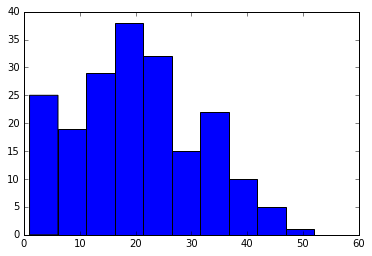

In [148]:
# we have around 200 users and 4000 plays, so around 20 plays per user. let's quickly examine the distribution of plays per user

# this will show a histogram with the distribution of plays per user
plt.hist(pd.pivot_table(data=songs,values='id',index='user_id',aggfunc='count'),bins='auto')
plt.show()
# looks like most users are around the average of 20 plays, with a long tail extending towards a max of ~50 plays

In [149]:
# viewed another way, let's see how many users are in 10 percentile-based buckets
pd.qcut(pd.pivot_table(data=songs,values='id',index='user_id',aggfunc='count'),10).value_counts(sort=False)
# The bottom 10% of users - 22 people - have between 1-5 plays, while the top 10%, consisting of 19 users, have 35-52 plays
# nothing about this seems peculiar, so let's move ahead

[1, 5]      22
(5, 10]     19
(10, 15]    24
(15, 17]    15
(17, 19]    20
(19, 23]    23
(23, 26]    20
(26, 31]    15
(31, 35]    19
(35, 52]    19
Name: id, dtype: int64

## Part 1 - Summary Statistics

Here, we will answer the three questions posed by the CEO that can be computed from the available data without any predictive modeling. They are as follows:

--What are the top 3 and the bottom 3 states in terms of number of users?  
--What are the top 3 and the bottom 3 states in terms of user engagement? You can choose how to mathematically define user engagement. What the CEO cares about here is in which states users are using the product a lot/very little.  
--The CEO wants to send a gift to the first user who signed-up for each state. That is, the first user who signed-up from California, from Oregon, etc. Can you give him a list of those users?

#### Top and Bottom States for Users

In [150]:
# to find unique users per state, we will use a pivot table and specify the aggregation function to be counting the number 
# of unique entries
user_state_counts = pd.pivot_table(data=songs,values='user_id',index='user_state',aggfunc = lambda x: len(x.unique())).copy()

# reshape by sorting in descending order
user_state_counts.sort(ascending=False)

# show the series
user_state_counts

C:\Users\jzell\Anaconda2\lib\site-packages\ipykernel\__main__.py:6: FutureWarning: sort is deprecated, use sort_values(inplace=True) for INPLACE sorting


user_state
New York          23
California        21
Texas             15
Pennsylvania       9
Ohio               9
Florida            7
Illinois           7
Georgia            6
New Jersey         6
North Carolina     6
Massachusetts      6
Michigan           5
Wisconsin          5
Maryland           5
Louisiana          5
Missouri           5
Tennessee          5
Indiana            4
Minnesota          4
Alabama            4
West Virginia      3
Oregon             3
Colorado           3
Kentucky           3
South Carolina     3
Mississippi        3
Oklahoma           2
Utah               2
Virginia           2
Washington         2
Arkansas           2
Alaska             2
North Dakota       1
Kansas             1
Iowa               1
Rhode Island       1
Nebraska           1
Idaho              1
Connecticut        1
New Mexico         1
Arizona            1
Name: user_id, dtype: int64

Shown above, we have a list of the number of unique users per state. New York, California, and Texas are the top three and are far ahead of other staes in terms of unique users. At the bottom, nine states are tied with one user each: ND, KS, IA, RI, NE, ID, CT, NM, and AZ. We can see that the number of users roughly correlates to state population, as our top three states are three of the most populated, and the bottom states tend to be less populated. We will need to consider how to correct for this correlation with population when defining user engagement.

#### User Engagement
The CEO wants to know which states have users that are using the product a lot or a little. As discussed above, more populous states have more users, so we must account for this by using some sort of per-user metric rather than looking at total plays. The most straightforward metric is average plays per user, which captures how active each user is and accounts for variance in users per state.

To find average plays per user in each state, we will take the same pivot table as above - which shows unique users per state - and calculate it again while removing the count "unique" designation so that we end up with total plays (rows) in each state. Then we can simply divide the second series by the first to get an average for each state.

In [151]:
# to find unique users per state, we will use a pivot table and specify the aggregation function to be counting the number 
# of unique entries
state_play_counts = pd.pivot_table(data=songs,values='user_id',index='user_state',aggfunc = 'count').copy()

# reshape by sorting in descending order
state_play_counts.sort(ascending=False)

# show the series
state_play_counts

C:\Users\jzell\Anaconda2\lib\site-packages\ipykernel\__main__.py:6: FutureWarning: sort is deprecated, use sort_values(inplace=True) for INPLACE sorting


user_state
New York          469
California        425
Texas             230
Ohio              209
Florida           180
Pennsylvania      179
North Carolina    154
Illinois          149
Georgia           135
Missouri          127
New Jersey        117
Maryland          112
Louisiana         105
Alabama           104
Tennessee         102
Wisconsin          95
Massachusetts      91
Mississippi        85
South Carolina     85
Michigan           80
Kentucky           78
Oregon             62
Alaska             58
Indiana            55
Colorado           54
Oklahoma           49
Minnesota          42
Washington         41
West Virginia      38
Utah               38
Nebraska           36
Arkansas           34
Rhode Island       27
North Dakota       26
Idaho              26
Iowa               23
Arizona            22
Virginia           17
New Mexico         17
Connecticut        16
Kansas              8
Name: user_id, dtype: int64

In [152]:
# create a dataframe of the counts of users in each state and rename column
user_engagement = pd.DataFrame(data=user_state_counts,index=user_state_counts.index)
user_engagement.rename(columns={'user_id': 'user_count'}, inplace=True)

# add total plays for each state as a column in DF
user_engagement['total_plays'] = state_play_counts

# calculate average plays per user
user_engagement['plays_per_user'] = user_engagement['total_plays']/(1.0*user_engagement['user_count'])

# sort by plays per user and show
user_engagement = user_engagement.sort(columns='plays_per_user',ascending=False)
user_engagement

C:\Users\jzell\Anaconda2\lib\site-packages\ipykernel\__main__.py:12: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


,user_count,total_plays,plays_per_user
user_state,,,
Nebraska,1,36,36.000000
Alaska,2,58,29.000000
South Carolina,3,85,28.333333
Mississippi,3,85,28.333333
Rhode Island,1,27,27.000000
Alabama,4,104,26.000000
Kentucky,3,78,26.000000
North Dakota,1,26,26.000000
Idaho,1,26,26.000000


Using the metric of plays per user, we see that the top three states are NE, AK, and SC, with values between 28 and 36. The bottom three are MN, VA, and KS, ranging from 8 to 10.5. However, we can also see that each of these states only have a few users, so we should be wary about drawing conclusions.

Let's take another look at the same data, restricting to states with 5 or more users.

In [153]:
user_engagement_subset = user_engagement[user_engagement['user_count'] >= 5]
user_engagement_subset

,user_count,total_plays,plays_per_user
user_state,,,
Florida,7,180,25.714286
North Carolina,6,154,25.666667
Missouri,5,127,25.400000
Ohio,9,209,23.222222
Georgia,6,135,22.500000
Maryland,5,112,22.400000
Illinois,7,149,21.285714
Louisiana,5,105,21.000000
Tennessee,5,102,20.400000


When we restrict to 5 or more users, the top three states are FL, NC, and MO, all with plays per user around 25. The bottom states are MI, TX, and MA, all around 15-16 plays per user. This range is much smaller than the overall range for all states, which makes sense, as variance decreases as sample size grows, all else being equal. 

To take a slightly more complicated approach, we can extend the plays per user metric to be plays per user-day. This will capture how active users are on a daily basis, which accounts for the fact that users in different states may have been using the product for varying amounts of time. Because of this, total plays per user may not tell the whole story, if, for example, users in FL have an average tenure of twice the length of users in MI. 

To calculate plays per user-day, we will calculate each user's tenure by looking at their sign-up date. Although we do not know exactly when the data was collected, we can look at the most recent sign-up date and estimate that the sample comes from the following day. After calculating each user's tenure, we can sum the total number of user-days for each state and divide total plays by this amount to find plays per user-day. 

In [154]:
# import packages
from dateutil.parser import parse
from datetime import timedelta

In [155]:
# to keep data size as small as possible, we can just grab a unique list of each user, sign-up date, and state
user_tenure = songs[['user_id','user_sign_up_date','user_state']].drop_duplicates()

In [156]:
# check to ensure it has the same number of rows as the number of unique users - this ensures users are only listed with one
# state and one sign-up date, so it's a good sanity check
len(user_tenure)
# it does!

196

In [157]:
# convert date column to date object for analysis
user_tenure['user_sign_up_date'] = user_tenure['user_sign_up_date'].map(lambda x: parse(str(x)))

# print max to find most recent sign-up
user_tenure['user_sign_up_date'].max()

Timestamp('2015-05-20 00:00:00')

In [158]:
# create date as day after last sign-up - 5/21/2015
maxdate = parse(str('2015-05-21'))

# create tenure as difference in maxdate and sign up date, convert to days
user_tenure['tenure'] = maxdate - user_tenure['user_sign_up_date']
user_tenure['tenure'] = user_tenure['tenure'].map(lambda x: x.days)

In [159]:
# check to see it looks how we'd hope
user_tenure.head()

,user_id,user_sign_up_date,user_state,tenure
0,122,2015-05-16,Louisiana,5
1,3,2015-05-01,Ohio,20
2,35,2015-05-04,New Jersey,17
3,126,2015-05-16,Illinois,5
4,6,2015-05-01,New Jersey,20


In [160]:
# add column to user engagement DF that is pivot table of tenure DF, summed for each state
user_engagement['user_days'] = pd.pivot_table(data=user_tenure,values='tenure',index='user_state',aggfunc=np.sum)

# create engagement column that is quotient of total plays and total user days for each state
user_engagement['plays_per_user_day'] = (user_engagement['total_plays']*1.0)/user_engagement['user_days']

In [161]:
# see how it looks
user_engagement.head()

,user_count,total_plays,plays_per_user,user_days,plays_per_user_day
user_state,,,,,
Nebraska,1,36,36.000000,5,7.200000
Alaska,2,58,29.000000,10,5.800000
South Carolina,3,85,28.333333,32,2.656250
Mississippi,3,85,28.333333,47,1.808511
Rhode Island,1,27,27.000000,2,13.500000


In [162]:
# sort by plays per user-day and show
user_engagement = user_engagement.sort(columns='plays_per_user_day',ascending=False)
user_engagement

C:\Users\jzell\Anaconda2\lib\site-packages\ipykernel\__main__.py:2: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  from ipykernel import kernelapp as app


,user_count,total_plays,plays_per_user,user_days,plays_per_user_day
user_state,,,,,
Rhode Island,1,27,27.000000,2,13.500000
Idaho,1,26,26.000000,2,13.000000
Iowa,1,23,23.000000,2,11.500000
Colorado,3,54,18.000000,5,10.800000
Oklahoma,2,49,24.500000,6,8.166667
Nebraska,1,36,36.000000,5,7.200000
North Dakota,1,26,26.000000,4,6.500000
Washington,2,41,20.500000,7,5.857143
Alaska,2,58,29.000000,10,5.800000


This method of analysis gives us a totally different view. Now, our most engaged states are RI, ID, and IA, all averaging over 10 plays per user per day. The least engaged states are UT, NM, and MN, with less than 1.4 plays per user per day. However, we are again running into the issue of only a few users for many states. Let's take another look with the same filter as before - only states with five or more users 

In [163]:
user_engagement_subset = user_engagement[user_engagement['user_count'] >= 5]
user_engagement_subset

,user_count,total_plays,plays_per_user,user_days,plays_per_user_day
user_state,,,,,
Louisiana,5,105,21.000000,31,3.387097
Missouri,5,127,25.400000,38,3.342105
Wisconsin,5,95,19.000000,30,3.166667
Tennessee,5,102,20.400000,40,2.550000
California,21,425,20.238095,177,2.401130
Florida,7,180,25.714286,77,2.337662
Illinois,7,149,21.285714,65,2.292308
North Carolina,6,154,25.666667,69,2.231884
Georgia,6,135,22.500000,63,2.142857


As before, we see a large drop in the spread of plays per user-day when restricting to states with five or more users. Our top three states are LA, MO, and WI. Only Missouri shows up again compared to the list that uses plays per user irrespective of time. Looking at the bottom states, Michigan appears again, this time accompanied by NJ and MD. 

Depending on the business goals and revenue model of the product, either of these metrics (total plays per user or plays per user per day) could be useful in determining which states have more and less engaged users. If, for example, ad revenue is determined by how many users are active and listening at any given time, then engagement per day is extremely relevant. Conversely, if costs in the form of royalties are determined by total plays of each song, then total engagement is just as important.

#### First User in Each State

To find the first user in each state, we can take our already existing DF that stores each user, state, and sign-up date, and iterate through it, finding the minimum date (or maximum tenure) for each state. 

In [164]:
# check that max tenure and min sign-up date yield the same location
[user_tenure['tenure'].idxmax(axis=0)], [user_tenure['user_sign_up_date'].idxmin(axis=0)]
# good!

([1], [1])

In [165]:
# check the opposite
[user_tenure['tenure'].idxmin(axis=0)], [user_tenure['user_sign_up_date'].idxmax(axis=0)]
# also good!

([11], [11])

In [166]:
# create empty list to store first user in each state
first_user_list = []

# get unique list of states
states = list(user_tenure['user_state'].unique())

# loop through each state and do the followng:
for i in states:
    # create temporary DF of just one state
    tenure_temp = user_tenure[user_tenure['user_state'] == i]
    # add state and user ID that corresponds to the max tenure for that state to the list
    first_user_list.append((i, tenure_temp['user_id'][tenure_temp['tenure'].idxmax(axis=0)]))
    

In [167]:
# show the list - each tuple represents a state and the user id with the longest tenure in that state
first_user_list

[(u'Louisiana', 50),
 (u'Ohio', 3),
 (u'New Jersey', 6),
 (u'Illinois', 45),
 (u'Texas', 7),
 (u'Rhode Island', 174),
 (u'Oregon', 1),
 (u'California', 39),
 (u'New York', 19),
 (u'Wisconsin', 32),
 (u'Tennessee', 70),
 (u'Maryland', 18),
 (u'Michigan', 13),
 (u'Pennsylvania', 11),
 (u'Missouri', 85),
 (u'Alabama', 5),
 (u'Oklahoma', 119),
 (u'Washington', 125),
 (u'Idaho', 165),
 (u'Kentucky', 34),
 (u'Arkansas', 78),
 (u'Connecticut', 127),
 (u'Colorado', 173),
 (u'Georgia', 20),
 (u'Utah', 29),
 (u'North Carolina', 2),
 (u'Alaska', 106),
 (u'Mississippi', 23),
 (u'Florida', 41),
 (u'West Virginia', 60),
 (u'South Carolina', 64),
 (u'Massachusetts', 15),
 (u'Virginia', 142),
 (u'Indiana', 102),
 (u'Iowa', 178),
 (u'Minnesota', 8),
 (u'North Dakota', 135),
 (u'New Mexico', 4),
 (u'Nebraska', 134),
 (u'Arizona', 105),
 (u'Kansas', 177)]

In [168]:
# let's spot check to be safe
user_tenure[user_tenure['user_state'] == 'Colorado'] # my home state!

,user_id,user_sign_up_date,user_state,tenure
44,181,2015-05-20,Colorado,1
118,173,2015-05-19,Colorado,2
300,166,2015-05-19,Colorado,2


It appears we have a tie - users 173 and 166 signed up on the same date, but only user 173 made it into the list. if the CEO just wants to send a gift to one person from each state in the case of a tie, we can use the above list. If not, we can create another list that stores each user ID with the maximum tenure in each state, and let the
CEO make the decision. let's create that list below.

We'll create it by looping through each state, and instead storing **all** user IDs with the maximum tenure.

In [169]:
# create empty list to store first user in each state
first_user_list_ties = []

# get unique list of states
states = list(user_tenure['user_state'].unique())

# loop through each state and do the followng:
for i in states:
    # create temporary DF of just one state
    tenure_temp = user_tenure[user_tenure['user_state'] == i]
    # filter this DF to all rows where the tenure is equal to the max tenure 
    tenure_temp_max = tenure_temp[tenure_temp['tenure'] == tenure_temp['tenure'].max()]
    # for each user ID in the filtered DF, add the state and user ID to the final list
    for j in tenure_temp_max['user_id']:
        first_user_list_ties.append((i, j))

In [170]:
# view the final list
first_user_list_ties

[(u'Louisiana', 50),
 (u'Ohio', 3),
 (u'New Jersey', 6),
 (u'Illinois', 45),
 (u'Texas', 7),
 (u'Rhode Island', 174),
 (u'Oregon', 1),
 (u'California', 39),
 (u'California', 44),
 (u'New York', 19),
 (u'New York', 22),
 (u'New York', 27),
 (u'New York', 12),
 (u'New York', 10),
 (u'Wisconsin', 32),
 (u'Tennessee', 70),
 (u'Maryland', 18),
 (u'Michigan', 13),
 (u'Pennsylvania', 11),
 (u'Missouri', 85),
 (u'Alabama', 5),
 (u'Oklahoma', 119),
 (u'Washington', 125),
 (u'Idaho', 165),
 (u'Kentucky', 34),
 (u'Arkansas', 78),
 (u'Connecticut', 127),
 (u'Colorado', 173),
 (u'Colorado', 166),
 (u'Georgia', 20),
 (u'Georgia', 16),
 (u'Utah', 29),
 (u'North Carolina', 2),
 (u'Alaska', 106),
 (u'Mississippi', 23),
 (u'Mississippi', 26),
 (u'Florida', 41),
 (u'Florida', 43),
 (u'West Virginia', 60),
 (u'South Carolina', 64),
 (u'Massachusetts', 15),
 (u'Virginia', 142),
 (u'Indiana', 102),
 (u'Iowa', 178),
 (u'Minnesota', 8),
 (u'Minnesota', 21),
 (u'North Dakota', 135),
 (u'New Mexico', 4),
 (u'Ne

In [171]:
# The above list passes the spot check with CO - it includes both users 173 and 166. Let's see how many additional users we have.
len(first_user_list), len(first_user_list_ties)

(41, 51)

When accounting for ties, we now have 51 users in the list of "first" users in each state. This adds ten additional users across 41 states. My recommendation to the CEO would be to send the gift to all 51 users, rather than just one per state, because ten additional gifts is likely much cheaper than a possible public relations fiasco or discrimination accusations from only sending gifts to one user in each state. Alternatively, we could seek out more granular sign-up data and determine which user was actually first to sign up in each state.

## Part 2 - Recommendation Model

--Build a function that takes as an input any of the songs in the data and returns the most likely song to be listened next. That is, if, for instance, a user is currently listening to "Eight Days A Week", which song has the highest probability of being played right after it by the same user? This is going to be v1 of a song recommendation model.  
--How would you set up a test to check whether your model works well and is improving engagement?

Before we attempt any predictive modeling or even simpler methods of prediction, we need to modify our data so we can capture what the 'next song' is. That is to say, for each observation, which song did the user play next? This way, we have our dependent variable and can begin to explore relationships between it and the rest of the data. To do this, we will split the dataframe by user, sort from oldest to most recent play, and add a column containing the next song played for each song (except the last, since there is no next song). We will also include the previous two songs for possible use in later predictive modeling, but must be aware that each additional lag will decrease the amount of usable data since it will require excluding the first few observations that do not have enough previous songs.

In [172]:
# create unique list of users
users = list(songs['user_id'].unique())

# initialize empty DF with the same columns as song data
songs_v2 = pd.DataFrame(columns=songs.columns.values)
# add empty columns for the next song and previous two songs
songs_v2['next_song'] = ''
songs_v2['prev_song'] = ''
songs_v2['prev_song_2'] = ''

# for each user, do the following:
for i in users:
    # slice songs DF into just this user's activity and sort by time played - oldest to newest
    temp = songs[songs['user_id'] == i]
    temp = temp.sort_values(by='time_played')
    # create next song column by shifting the song played column back by one
    temp['next_song'] = temp['song_played'].shift(-1)
    
    # create prev song columns by shifting song played column forward one and two rows
    temp['prev_song'] = temp['song_played'].shift(1)
    temp['prev_song_2'] = temp['song_played'].shift(2)
    
    # append temporary DF to our new songs DF - this will have all of the old data plus the new column
    songs_v2 = songs_v2.append(temp)

# let's take a look
songs_v2.head()

,id,song_played,time_played,user_id,user_sign_up_date,user_state,next_song,prev_song,prev_song_2
3053,KKSBLIUDTP,Revolution,2015-06-01 14:06:23,122.0,2015-05-16,Louisiana,Get Back,NaN,NaN
1904,YYAFSKFFCP,Get Back,2015-06-01 17:38:00,122.0,2015-05-16,Louisiana,Reprise / Day in the Life,Revolution,NaN
1994,TXZXXZLKZL,Reprise / Day in the Life,2015-06-02 22:32:25,122.0,2015-05-16,Louisiana,Paperback Writer,Get Back,Revolution
3995,MKVEXMRJGF,Paperback Writer,2015-06-03 08:26:26,122.0,2015-05-16,Louisiana,Birthday,Reprise / Day in the Life,Get Back
3424,RWAYCFCHYJ,Birthday,2015-06-03 22:32:13,122.0,2015-05-16,Louisiana,IT WON'T BE LONG,Paperback Writer,Reprise / Day in the Life


In [173]:
# let's store the last song for each user separately in case we need it later
songs_last = songs_v2[songs_v2['next_song'].isnull() == True]

In [174]:
# double check we got all the rows
len(songs_v2)
# success!

4000

Looking above, we were able to capture the next song for each user's activity. However, we know that the last song played by each user will not have a next song, meaning that our data will have some NA's. Let's check how many using our previously-defined *fillprc* function and make a decision from there. 

In [176]:
fillprc(songs_v2)

[('next_song', 0.951), ('prev_song', 0.951), ('prev_song_2', 0.90275)]

We see that just under 5% of the data is each user's last song, so we do not have an observation to view as the next song. Since this is a fairly small number and we have a few thousand rows of data, we will drop these observations from our first attempt at a model. We can ignore the blank entries for previous songs since we will not be using them for now.

Before any complicated predictive modeling, let's do a little bit of exploratory analysis on the relationship between one song and the next. Then, we will establish a simple baseline against which we will compare more complicated predictive approaches. 

In [177]:
# remove observations with no next_song
songs_v2 = songs_v2.dropna(subset=['next_song'])

In [178]:
# let's take a quick look at a crosstabulation of this data
pd.crosstab(songs_v2['song_played'],songs_v2['next_song'])

next_song,A Day In The Life,A Hard Day's Night,A Saturday Club Xmas/Crimble Medley,ANYTIME AT ALL,Across The Universe,All My Loving,All You Need Is Love,And Your Bird Can Sing,BAD BOY,Baby You're A Rich Man,...,We Can Work It Out,When I'm 64,While My Guitar Gently Weeps,Wild Honey Pie,With a Little Help From My Friends,YOUR MOTHER SHOULD KNOW,Yellow Submarine,Yesterday,You Never Give Me Your Money,You're Going To Lose That Girl
song_played,,,,,,,,,,,,,,,,,,,,,
A Day In The Life,7,0,0,0,0,0,2,0,0,0,...,7,0,4,3,3,0,0,3,0,0
A Hard Day's Night,0,0,0,0,0,0,0,0,0,0,...,1,0,1,0,0,0,0,0,0,0
A Saturday Club Xmas/Crimble Medley,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ANYTIME AT ALL,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Across The Universe,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
All My Loving,0,0,0,0,0,0,0,1,0,0,...,1,0,2,0,0,0,0,0,0,0
All You Need Is Love,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,1,0,0,0,0,0
And Your Bird Can Sing,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
BAD BOY,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [179]:
# Let's test for independence of these two variables using a chi-squared test
from scipy.stats import chi2_contingency
chi2_contingency(pd.crosstab(songs_v2['song_played'],songs_v2['next_song']), correction=False)[1]  
# the 2nd item in this object is the p-value


0.026807208071338403

We see the p-value for independence of test and conversion is fairly small, indicating that we can reject the null hypothesis of independence among these two variables at the 5% level, but not the 1% level. This implies there is at least some relationship between the song played and the next song, so there should be some insight to uncover via predictive modeling. 

Since we care about recommending songs, we are in a situation where out-of-sample prediction is relevant. Therefore, to evaluate different predictive models, we will divide the data into training and test sets and use out-of-sample fit metrics as a basis for evaluation. We are effectively dealing with a classification problem with a very large number of levels (around 100 possible songs), and at this point, we have not defined what it means for songs to be "close" to each other, so the metric that makes the most sense for now is accuracy - simply whether the prediction was correct or not. With 99 different songs, a totally random or naive model - such as choosing the same song every time - should be correct 1/99 times or about 1%. So, any rate above this can be considered an improvement. 

To set a baseline for prediction, let's start with a couple of slightly more nuanced approaches than a random choice, but not yet a full-fledged predictive model. For this, we will simply pick the most frequently played next song overall, and the most frequently played next song for each song, and look at how well these predict out-of-sample.

In [180]:
# First, import train_test_split function and create test and train data
from sklearn.model_selection import train_test_split
train1, test1 = train_test_split(songs_v2, test_size = .33, random_state=47)

The first approach we will try is to just pick the most frequently played next song, which is to say the most frequently played song overall, and predict this as the next song in every instance. However, ths isn't very exciting nor practical, as in practice we would not want to play the same song after every play for each user. 

In [181]:
# what is the most common next song in the training set?
train1['next_song'].value_counts().idxmax()
# This song has got to be good looking because it's so hard to see!

u'Come Together'

In [182]:
# quick check - is this the most frequently played song overall?
songs['song_played'].value_counts().idxmax()
# yes!

u'Come Together'

In [183]:
# store first prediction for test set as Come Together for all songs
test1['prediction1'] = 'Come Together'

C:\Users\jzell\Anaconda2\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [184]:
# create boolean to check if prediction matches next song
test1['correct1'] = test1['next_song'] == test1['prediction1']

C:\Users\jzell\Anaconda2\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [185]:
# show count of correct and incorrect
test1['correct1'].value_counts()

False    1133
True      123
Name: correct1, dtype: int64

In [186]:
# show correct percentage
(1.0*test1['correct1'].value_counts().ix[True])/(test1['correct1'].value_counts().ix[False]+test1['correct1'].value_counts().ix[True])

0.09792993630573249

In our test set of around 1250 song plays, we see that predicting "Come Together" results in correct predictions about 10% of the time, because overall around 10% of total plays were "Come Together." This isn't a very exciting or useful result, but shows the ways we can use statistics to improve predictions. Next, let's try to get a little more creative and predict the most frequently played next song for each song and see how this performs.

In [187]:
# in train data, compute crosstab and identify most frequent next song for each song, storing as dataframe 
# these will be our predictions for each song
train_maxsongs = pd.DataFrame(pd.crosstab(train1['song_played'],train1['next_song']).idxmax(axis=1),columns=['prediction'])

In [188]:
# check how it looks
train_maxsongs.head()
# we see a bit of variance, which is nice. let's see how it performs.

,prediction
song_played,
A Day In The Life,Come Together
A Hard Day's Night,Let It Be
ANYTIME AT ALL,Can't Buy Me Love
Across The Universe,A Day In The Life
All My Loving,Hey Jude


In [189]:
# create a dictionary to store predictions
preds2 = {}

# loop through each item in the index of the DF and create a key-value pair storing the prediction
for i in train_maxsongs.index.values:
    preds2[i] = train_maxsongs['prediction'][i]

In [190]:
# create a new prediction column in test1 by replacing song_played using the dictionary we created
test1['prediction2'] = test1['song_played'].replace(preds2)

C:\Users\jzell\Anaconda2\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [190]:
# what kind of predictions are we making?
test1['prediction2'].value_counts()

Come Together                          621
Revolution                             329
Back In the U.S.S.R.                   122
Get Back                                79
A Day In The Life                       40
Hello Goodbye                           24
Helter Skelter                          10
While My Guitar Gently Weeps             7
Let It Be                                5
Baby You're A Rich Man                   4
I Feel Fine                              3
Can't Buy Me Love                        3
Drive My Car                             3
You're Going To Lose That Girl           2
THE CONTINUING STORY OF BUNG             2
A Saturday Club Xmas/Crimble Medley      2
Name: prediction2, dtype: int64

In [188]:
# create boolean to check if prediction matches next song
test1['correct2'] = test1['next_song'] == test1['prediction2']

C:\Users\jzell\Anaconda2\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [189]:
# show correct percentage
(1.0*test1['correct2'].value_counts().ix[True])/(test1['correct2'].value_counts().ix[False]+test1['correct2'].value_counts().ix[True])

0.0732484076433121

Our out-of-sample accuracy rate falls to around 7% when predicting the most frequent next song for each song. However, this scenario is slightly more realistic since we are at least playing different songs for users based on their current song. At any rate, 7% accuracy is still above the totally random threshold of just over 1%. Let's move on to actual predictive models. Since we are more concerned with out-of-sample predictive power rather than interpretability, we can use more complex models such as boosting and random forests.

Our first attempt will be to predict the next song using just the previous song in random forest and boosting models. Then, we will incorporate more information such as user demographics.

In [11]:
# import the packages we need
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.cross_validation import train_test_split

C:\Users\jzell\Anaconda2\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [9]:
# Let's attempt an initial random forest using one predictor variable - the previous song
# initialize model object and formula  
rf1 = RandomForestClassifier()
rf1_formula = 'next_song ~ song_played'

# create target and explanatory DFs and split into test and train
y,x = patsy.dmatrices(rf1_formula,songs_v2,return_type='dataframe')
X_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size=0.33, random_state=47)

# specifcy parameters to search through for grid search
parameters = dict(n_estimators=[10, 25, 50, 100],\
                  max_features=[10,50,'sqrt'],\
                  max_depth=[1,5,10,50,100],\
                  random_state=[42])

# search through parameters to find optimal model in terms of accuracy
rf1_cv = GridSearchCV(rf1, param_grid = parameters)

# fit model to training data
rf1_cv.fit(X_train, Y_train)

# create predictions and compute and print accuracy
Y_preds = rf1_cv.predict(X_test)
print "Accuracy: ", accuracy_score(Y_test, Y_preds)

Accuracy:  0.000796178343949


In [30]:
# let's run without grid search to see if it was useful
# initialize model
rf1_f = RandomForestClassifier()

# fit model to same training data
rf1_f.fit(X_train, Y_train)

# create predictions and compute and print accuracy
Y_preds = rf1_f.predict(X_test)
print "Accuracy: ", accuracy_score(Y_test, Y_preds)

Accuracy:  0.0017667844523


We see that accuracy isn't any better with the grid search, so the automatic preferences within scikit-learn are just as good as anything we've put into the cross validation. At any rate, let's focus on adding more features and/or trying different types of models rather than fine-tuning parameters. Next, we will run through a few different iterations of a random forest with different independent variables. 

In [31]:
# initialize model object and formula, including user state this time
rf2 = RandomForestClassifier()
rf2_formula = 'next_song ~ song_played + user_state'

# create target and explanatory DFs and split into test and train
y,x = patsy.dmatrices(rf2_formula,songs_v2,return_type='dataframe')
X_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size=0.33, random_state=47)

# fit model to training data
rf2.fit(X_train, Y_train)

# create predictions and compute and print accuracy
Y_preds = rf2.predict(X_test)
print "Accuracy: ", accuracy_score(Y_test, Y_preds)

Accuracy:  0.015923566879


Our accuracy scores for the first two random forest models are not good - they are close to the totally naive approach and are much worse than predicting the most frequent next song for each song.

Next, we will train a couple more random forests incorporating data about the previous songs. We must note that each time we add a 'lagged' song variable, we lose about 5% of the data, since we can no longer use the first song for each user because they will not have a previous song. This is on top of already dropping the last song for each user since there is no next song. Thus, there is a tradeoff in (potentially) increasing predictive accuracy but losing data and therefore robustness in the process. 

In [32]:
# create copy of DF for manipulation
songs_v3 = songs_v2.copy()
# drop observations that are missing previous song
songs_v3 = songs_v3.dropna(subset = ['prev_song'])


### create model and display results in same process as before, this time including previous song in the formula
rf3 = RandomForestClassifier()
rf3_formula = 'next_song ~ song_played + user_state + prev_song'
y,x = patsy.dmatrices(rf3_formula,songs_v3,return_type='dataframe')
X_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size=0.33, random_state=47)

rf3.fit(X_train, Y_train)
Y_preds = rf3.predict(X_test)
print "Accuracy: ", accuracy_score(Y_test, Y_preds)

Accuracy:  0.00587248322148


In [33]:
# create copy of DF for manipulation
songs_v3 = songs_v2.copy()
# drop observations that are missing two previous songs
songs_v3 = songs_v3.dropna(subset = ['prev_song','prev_song_2'])

### create model and display results in same process as before, this time including new variables
rf3 = RandomForestClassifier()
rf3_formula = 'next_song ~ song_played + user_state + prev_song + prev_song_2'
y,x = patsy.dmatrices(rf3_formula,songs_v3,return_type='dataframe')
X_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size=0.33, random_state=47)

rf3.fit(X_train, Y_train)
Y_preds = rf3.predict(X_test)
print "Accuracy: ", accuracy_score(Y_test, Y_preds)

Accuracy:  0.0017667844523


In [34]:
### accuracy didn't really get any better, let's also add a dummy variable for user ID
### create model and display results in same process as before, this time including new variables
rf4 = RandomForestClassifier()
rf4_formula = 'next_song ~ song_played + user_state + C(user_id)'
y,x = patsy.dmatrices(rf4_formula,songs_v2,return_type='dataframe')
X_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size=0.33, random_state=47)

rf4.fit(X_train, Y_train)
Y_preds = rf4.predict(X_test)
print "Accuracy: ", accuracy_score(Y_test, Y_preds)

Accuracy:  0.0127388535032


None of the random forest classifiers were able to get an accuracy far above the totally random approach. Let's try another type of classifier that can perform well in a problem with a large number of classes - the k-nearest neighbors model. We will start by trying a few different numbers of neighbors to see how accuracy changes. As we add more neighbors, we are decreasing the variance of our model since each prediction will be based on more "neighbors" and therefore less sensitive to changes in the data. Fewer neighbors may result in overfitting since there is a greater likelihood of chasing noise in the dataset, which would likely lead to poor performance in out-of-sample prediction. 

In [13]:
from sklearn.neighbors import KNeighborsClassifier

In [35]:
knn1 = KNeighborsClassifier(n_neighbors=1)

knn1_formula = 'next_song ~ song_played + user_state + C(user_id)'
y,x = patsy.dmatrices(knn1_formula,songs_v2,return_type='dataframe')
X_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size=0.33, random_state=47)

knn1.fit(X_train, Y_train)
Y_preds = knn1.predict(X_test)
print "Accuracy: ", accuracy_score(Y_test, Y_preds)

Accuracy:  0.0342356687898


In [36]:
knn1 = KNeighborsClassifier(n_neighbors=3)

knn1_formula = 'next_song ~ song_played + user_state + C(user_id)'
y,x = patsy.dmatrices(knn1_formula,songs_v2,return_type='dataframe')
X_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size=0.33, random_state=47)

knn1.fit(X_train, Y_train)
Y_preds = knn1.predict(X_test)
print "Accuracy: ", accuracy_score(Y_test, Y_preds)

Accuracy:  0.0103503184713


In [37]:
knn1 = KNeighborsClassifier(n_neighbors=5)

knn1_formula = 'next_song ~ song_played + user_state + C(user_id)'
y,x = patsy.dmatrices(knn1_formula,songs_v2,return_type='dataframe')
X_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size=0.33, random_state=47)

knn1.fit(X_train, Y_train)
Y_preds = knn1.predict(X_test)
print "Accuracy: ", accuracy_score(Y_test, Y_preds)

Accuracy:  0.00477707006369


Our best accuracy was achieved with a KNN model with one neighbor, with accuracy around 3.4%, or approximately 3 times better than a random model and more than 2 times better than the best random forest so far. Still, these are much worse than the simpler methods of simply picking the most common next songs.

Next, we will try a few more complex formulas for a KNN model with k=1 and see how they perform.

In [38]:
# create copy of DF for manipulation
songs_v3 = songs_v2.copy()
# drop observations that are missing two previous songs
songs_v3 = songs_v3.dropna(subset = ['prev_song','prev_song_2'])

knn2 = KNeighborsClassifier(n_neighbors=1)

knn2_formula = 'next_song ~ song_played + user_state + prev_song + C(user_id)'
y,x = patsy.dmatrices(knn2_formula,songs_v3,return_type='dataframe')
X_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size=0.33, random_state=47)

knn2.fit(X_train, Y_train)
Y_preds = knn2.predict(X_test)
print "Accuracy: ", accuracy_score(Y_test, Y_preds)

Accuracy:  0.0424028268551


In [39]:
knn2 = KNeighborsClassifier(n_neighbors=1)

knn2_formula = 'next_song ~ song_played + user_state + prev_song + prev_song_2 + C(user_id)'
y,x = patsy.dmatrices(knn2_formula,songs_v3,return_type='dataframe')
X_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size=0.33, random_state=47)

knn2.fit(X_train, Y_train)
Y_preds = knn2.predict(X_test)
print "Accuracy: ", accuracy_score(Y_test, Y_preds)

Accuracy:  0.0424028268551


Both of these models achieved an accuracy of around 4.2%, which is the best result so far. Next we will attempt one more classification model - the AdaBoost algorithm - to compare results. Of the two boosting methods, AdaBoost with the SAMME algorithm is more suited for classification with many classes because it does not need to train a separate learner for each class in each iteration as Gradient Boosting needs to do.

To do this, we need a little trick in our dependent variable. The algorithm in scikit-learn requires a single vector with integers for class labels, rather than a sparse matrix, be used as Y. So, we need to create a dictionary that contains all songs with a unique integer value, and use these values rather than the standard Y matrix created by patsy. Otherwise, we will use the same procedure to train this model.

In [25]:
from sklearn.ensemble import AdaBoostClassifier

In [37]:
# get unique list of songs and initialize empty dictionary
songslist = songs_v2['song_played'].unique()
songdict = {}

# store each unique song as a key and an integer as a value
for i in range(0,len(songslist)):
    songdict[songslist[i]] = i

In [ ]:
# create copy of DF for manipulation
songs_v3 = songs_v2.copy()
# drop observations that are missing two previous songs
songs_v3 = songs_v3.dropna(subset = ['prev_song'])

# initialize model object and formula, including previous song as it appears to improve accuracy
aboost1 = AdaBoostClassifier()
aboost1_formula = 'next_song ~ song_played + user_state + prev_song + C(user_id)'

# create DFs in same manner as before
y,x = patsy.dmatrices(aboost1_formula,songs_v3,return_type='dataframe')

# replace Y with a single vector of next_song, and replace that with integer values from our dictionary
y = songs_v3['next_song']
y = y.replace(songdict)

# perofmr test train split as before and train model
X_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size=0.33, random_state=47)
aboost1.fit(X_train, Y_train)

Y_preds = aboost1.predict(X_test)
print "Accuracy: ", accuracy_score(Y_test, Y_preds) 

This accuracy is too high, so I'm suspicious. Let's see what these predictions actually look like. We will take the vector of predictions, convert them back to song titles, and look at the value counts.

In [56]:
# create series of predictions to turn back into song titles
Y_ps = pd.Series(Y_preds)

# create reverse lookup dictionary to convert integers back to song titles
songdict_rev = {value: key for key, value in songdict.items()}

# replace song titles and show value counts
Y_ps = Y_ps.replace(songdict_rev)
Y_ps.value_counts()


Come Together                   1177
Hey Jude                           9
While My Guitar Gently Weeps       4
Got To Get You Into My Life        2
dtype: int64

Sure enough, AdaBoost is too smart for its own good. The best it could do was to essentially predict the most common song every time, which is what we have observed to be by far the most accurate approach thus far. 

At this point, we have reached an impasse with predictive modeling using the data we currently have. In absence of more details about users and songs, as well as with relatively few observations per user (only approximately 5-40 plays each), additional feature engineering would likely be a fruitless endeavor. As a final attempt, we will try a different recommendation approach: collaborative filtering. 

To do this, we will try to use all user's data to determine which songs are "similar," and use that as a basis to recommend songs. We will take each user's last song and use these as our out-of-sample test songs. This differs from traditional regression-based classifier models where we used the standard train-test split methodology, because the former approach requires a set of X's for each observation to predict our Y (the song played), whereas this approach draws insights from all songs at once. Once we have excluded each user's last song, we will take the rest of the songs and determine their count of plays for each user using a crosstabulation. This will yield a vector for each song, where each number in the vector corresponds to a play count for that song for a different user. Then, we will use the measure of cosine similarity to give a "closeness" score to each pair of songs, indicating how similar their pattern of plays-by-user is. Then, for each song, we will find its closest song (excluding itself, for which its closeness will be perfect), and recommend this as the next song. 

In [12]:
# create dataframe where each column is a vector of plays from each user
## from this, we will find the 'similarity' of each song to each other song (excluding the last song) and use this for recs
song_vecs = pd.DataFrame(pd.crosstab(songs_v2['user_id'],songs_v2['song_played']))

# initialize DF that will hold cosine similarities for each song-song combination
songs_cosine = pd.DataFrame(index=song_vecs.columns,columns=song_vecs.columns)

In [19]:
# import function to find cosine distance between two vectors. it is cosine distance, so we want the number to be as 
# small as possible - it will range from 0 to 1, with 0 meaning the two vectors are equal (excluding magnitude)
from scipy.spatial.distance import cosine

In [227]:
# check that function is working properly - this should give us a number close to zero
cosine(song_vecs.ix[:,"A Hard Day's Night"],song_vecs.ix[:,"A Hard Day's Night"])

# correct!

2.2204460492503131e-16

In [30]:
# loop through each song-song pair and do the following:
for i in songs_cosine.columns:
    for j in songs_cosine.columns:
        if i != j: # if songs are not the same, find the cosine distance, and subtract this from 1 so that we get larger numbers
            # corresponding to closer songs. this is purely for interpretability.
            songs_cosine.ix[i,j] = 1 - cosine(song_vecs.ix[:,i],song_vecs.ix[:,j])

In [31]:
# let's take a look
songs_cosine.head()

song_played,A Day In The Life,A Hard Day's Night,A Saturday Club Xmas/Crimble Medley,ANYTIME AT ALL,Across The Universe,All My Loving,All You Need Is Love,And Your Bird Can Sing,BAD BOY,Baby You're A Rich Man,...,We Can Work It Out,When I'm 64,While My Guitar Gently Weeps,Wild Honey Pie,With a Little Help From My Friends,YOUR MOTHER SHOULD KNOW,Yellow Submarine,Yesterday,You Never Give Me Your Money,You're Going To Lose That Girl
song_played,,,,,,,,,,,,,,,,,,,,,
A Day In The Life,NaN,0.243975,0.0771517,0.0890871,0.219578,0.352637,0.327327,0.13159,0.218218,0.109109,...,0.460046,0.031497,0.507394,0.245495,0.345512,0.0385758,0.304969,0.3279,0.0909241,0
A Hard Day's Night,0.243975,NaN,0,0,0.1,0.139876,0.111803,0,0,0,...,0.246718,0.129099,0.205552,0,0,0,0.05,0.198294,0.0745356,0
A Saturday Club Xmas/Crimble Medley,0.0771517,0,NaN,0,0,0,0,0,0,0,...,0.111456,0,0,0.176777,0,0,0,0,0,0
ANYTIME AT ALL,0.0890871,0,0,NaN,0,0.0851257,0,0.123091,0,0,...,0.0965234,0,0.132453,0,0.204124,0,0,0.120678,0,0
Across The Universe,0.219578,0.1,0,0,NaN,0.0932505,0,0,0,0,...,0.140981,0,0.120913,0,0,0,0,0.0440653,0,0


In [199]:
# check - what is "A Hard Day's Night"'s most similar song?
songs_cosine["A Hard Day's Night"].idxmax()
# Looks like our code has been working like a dog!

u'Come Together'

In [40]:
# initialize an empty dictionary to store recommendations
cosine_recs = {}

# for each song in our previously-created list, grab its "closest" song
for i in songslist:
    cosine_recs[i] = songs_cosine[i].idxmax()

In [44]:
# how does it look?
cosine_recs

{u'A Day In The Life': u'Revolution',
 u"A Hard Day's Night": u'Come Together',
 u'A Saturday Club Xmas/Crimble Medley': u'GIRL',
 u'ANYTIME AT ALL': u"Can't Buy Me Love",
 u'Across The Universe': u'Revolution',
 u'All My Loving': u'Let It Be',
 u'All You Need Is Love': u'A Day In The Life',
 u'And Your Bird Can Sing': u'All My Loving',
 u'BAD BOY': u'Hey Jude',
 u"Baby You're A Rich Man": u'GIRL',
 u'Back In the U.S.S.R.': u'Revolution',
 u'Birthday': u'Got To Get You Into My Life',
 u'Blackbird': u'Drive My Car',
 u"Can't Buy Me Love": u'Hello Goodbye',
 u'Come Together': u'Revolution',
 u'Cry For A Shadow': u"I've Just Seen A Face",
 u'Day Tripper': u'Revolution',
 u'Dear Prudence': u'Got To Get You Into My Life',
 u"Don't Let Me Down": u'Ticket to Ride',
 u'Drive My Car': u'Hello Goodbye',
 u'Eight Days A Week': u'Let It Be',
 u'Eleanor Rigby': u'Get Back',
 u"Everybody's Got Something To Hide Except Me And My Monk": u"I Want You (She's So Heavy)",
 u'Fixing A Hole': u'Sgt. Pepper/

In [225]:
# remove observations with no previous song - for users with only one play
songs_last = songs_last.dropna(subset=['prev_song'])

# define a function to get recommendation for each song
def get_rec(str):
    return cosine_recs[str]

# create prediction as the most similar song to the previously played song
## NOTE: here, we could alternatively get the most similar song to each user's most frequently played song, second to last song,
## etc. This is just one idea.
songs_last['prediction2'] = songs_last['prev_song'].map(get_rec)

In [228]:
# check to see if prediction is correct
songs_last['correct'] = songs_last['prediction2'] == songs_last['song_played']

# show correct percentage
(1.0*songs_last['correct'].value_counts().ix[True])/(songs_last['correct'].value_counts().ix[False]+songs_last['correct'].value_counts().ix[True])

0.072538860103626937

In [233]:
# what predictions are we making and are they correct?
pd.crosstab(songs_last['prediction2'],songs_last['correct'])

correct,False,True
prediction2,,
A Saturday Club Xmas/Crimble Medley,1,0
Birthday,7,0
Come Together,23,7
Everybody's Got Something To Hide Except Me And My Monk,1,0
Hello Goodbye,3,0
I'll Follow The Sun,1,0
I'm Down,1,0
Lovely Rita,3,0
Revolution,128,7


### Recommendation Model Commentary

After attempting a number of recommendation models, the collaborative filtering based on similar songs represents the best combination of accuracy and variety. Rather than using "features" of songs, we use their play counts by different users to represent different featuers. It predicts more than ten different songs, although predicts only two of them more than ten times. It also achieves an accuracy of around 7% on a small test sample of one song for each user, which is much better than a random guess of around 1%. It still falls short of the best prediction of simply picking the most popular song across the board, but that prediction mechanism is not realistic for reasons previously discussed.

In terms of scaling a recommendation model to production, the similar song approach is also reasonable. It does not require any information about a new user to generate recommendations, instead relying on data about song plays that can be updated in an off-cycle batch process so recommendations can be generated instantaneously and updated intermittently. Furthermore, more information about the song - BPM, key, who wrote it, etc. - could help us improve our definition of "similar" songs beyond just comparing plays across different users. As well, as the variety of songs and users grow, variety should increase, rather than just a few of the most common songs being recommended every time. However, this is the case for all predictive models - they get better with more data. Additionally, it is easy to impose filters on recommendations - for example, the most similar song that the user has not played before, or that the user has not played in the last 24 hours, or is by a different artist, etc. 

A more complex recommendation model could start from this baseline and use it as an input into recommending songs, while also considering factors like demography, user-generated ratings, etc. However, as a thought exercise, this recommendation model is a good place to start. Next steps could also include incorporating temporal elements into analysis - such as noticing that users listen to certain types of songs during specific times of day, or grouping user plays into "sessions" that take place together and weighing the input of these plays more strongly. 

### Conclusion
----How would you set up a test to check whether your model works well and is improving engagement?

To test our model's efficacy, we want to perform some A/B testing. First, we will need to randomly segment our users into test and control groups - for example, by looking at a user's ID and splitting on odd/even numbers. Then, the test group will be receive recommendations from the model, while the control group will see no changes. After a period of time, compare various engagement metrics for the two groups - total plays, plays per day, listening session time, etc. Then, some simple statisical tests can determine whether there is a statistically significant difference in engagment across the two groups. From this, conclusions about the effect of the recommendation model can be drawn.

Additionally, some features such as the ability to provide feedback such as taking surveys, rating recommendations, or turning on and off the recommendation feature will give some insight into how users perceive and use the new model.